## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-02 17:14:17,017 [INFO ] (MainThread) GPAC: power reset
2022-02-02 17:14:18,769 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-02 17:14:19,000 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-02 17:14:19,240 [INFO ] (MainThread) ibias = 45
2022-02-02 17:14:19,256 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-02 17:14:19,819 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 50.151368865825674, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0612799558568045, 'VDDD OC': False, 'VPC [mA]': -0.05099977002478552, 'VPCSWSF [mA]': 0.16558216720299715, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10109892318840588}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.0622801785996314,
 'BiasSF [mA]': 0.10109892318840588,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 50.151368865825674,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 2.502471747485684,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8049802771084336,
 'VDDP [mA]': 128.39714805315754,
 'VPC [V]': 1.2998506463536463,
 'VPC [mA]': 0.10599953834238034,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': 0.15907894032867997}

## ANALOG FRONT END CONFIGURATION

In [3]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-02 17:14:25,223 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-02 17:14:25,237 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-02 17:14:25,259 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-02 17:14:25,276 [INFO ] (MainThread) icasn = 0
2022-02-02 17:14:25,292 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-02 17:14:25,306 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-02 17:14:25,322 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-02 17:14:25,338 [INFO ] (MainThread) ithr = 5
2022-02-02 17:14:25,361 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-02 17:14:25,375 [INFO ] (MainThread) idb = 50
2022-02-02 17:14:25,391 [INFO ] (MainThread) idb = 892.5 nA
2022-02-02 17:14:25,407 [INFO ] (MainThread) ibias = 100
2022-02-02 17:14:25,423 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [4]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 53047 hits, total noisy pixels: 39
Enable MASKH 100
Got 105485 hits, total noisy pixels: 93
Enable MASKH 150
Got 28591 hits, total noisy pixels: 140
Enable MASKH 200
Got 160356 hits, total noisy pixels: 216
Enable MASKH 223
Got 38203 hits, total noisy pixels: 240
Enable MASKV 50
Got 127 hits, total noisy pixels: 240
Enable MASKV 100
Got 131 hits, total noisy pixels: 243
Enable MASKV 111
Got 94 hits, total noisy pixels: 246
Enable MASKD 50
Got 5 hits, total noisy pixels: 247
Enable MASKD 100
Got 14 hits, total noisy pixels: 247
Enable MASKD 150
Got 5 hits, total noisy pixels: 248
Enable MASKD 200
Got 117 hits, total noisy pixels: 251
Enable MASKD 250
Got 20 hits, total noisy pixels: 252
Enable MASKD 300
Got 51 hits, total noisy pixels: 252
Enable MASKD 350
Got 116 hits, total noisy pixels: 253
Enable MASKD 400
Got 18 hits, total noisy pixels: 256
Enable MASKD 447
Got 75 hits, total noisy pixels: 262
Checking again after masking
Got 15 hits, total noisy pixels: 265
No

# Configure injection and Select 1pixel 

2022-02-02 17:14:43,720 [INFO ] (MainThread) idb = 20
2022-02-02 17:14:43,736 [INFO ] (MainThread) idb = 367.5 nA
2022-02-02 17:14:43,759 [INFO ] (MainThread) vh = 1.80232283465V


Got 100 hits in 0.2 s


<IPython.core.display.Javascript object>


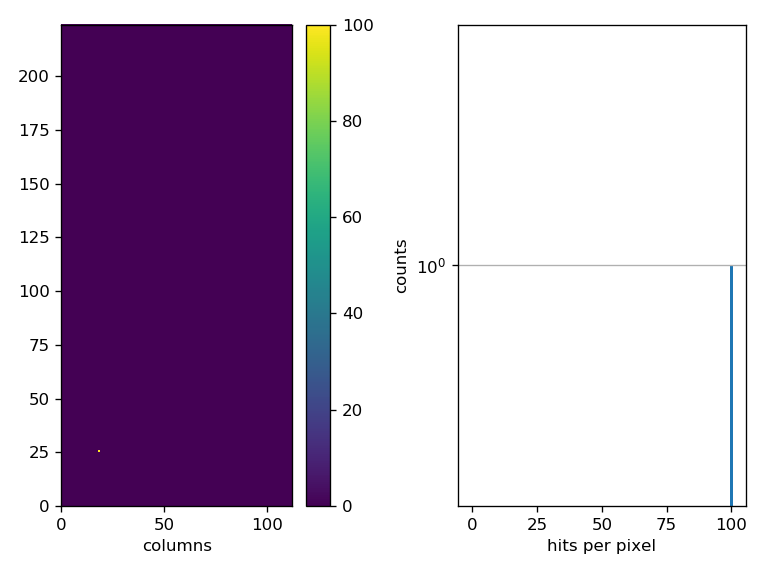

C:\ProgramData\Miniconda2\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
2022-02-02 17:14:46,282 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1200
0 (18, 25) 100


In [5]:
#chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
#chip['CONF_SR']['INJ_ROW'].setall(False)
#chip['CONF_SR']['INJ_ROW'][223:220]=True
#chip.write_conf()
col_to_inject = 18
row_to_inject = 25

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

chip['CONF_SR']['MASKV'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'][row_to_inject]=True
chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_HV'][col_to_inject//2]=True

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip.enable_injection(3, col_to_inject, row_to_inject)
chip.write_conf()

idb = chip.set_idb_dacunits(20,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]

# Threshold scan
## step by step

In [6]:
idb_dac = 20

idb = chip.set_idb_dacunits(idb_dac, 1)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
    
injlist = np.arange(50, 0, -1)
inj_low_dac = chip.get_vl_dacunits()
cnt = np.empty(len(injlist))
tot = np.empty(len(injlist))
inj_high = np.empty(len(injlist))

print "inj all_hits hits aveToT"
for inj_i, inj in enumerate(injlist):
    inj_high_pulse_dac = inj + inj_low_dac
    inj_high_pulse = chip.set_vh_dacunits(inj_high_pulse_dac, 0)
    chip.write_conf()

    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip.set_monoread()
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.2)
    
    ix = chip.interpret_data(chip['fifo'].get_data())
    ix_inj = ix[np.bitwise_and(ix["col"]==col_to_inject, ix["row"]==row_to_inject)]
    cnt[inj_i] = len(ix_inj)
    tot[inj_i] = np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
    inj_high[inj_i] = inj_high_pulse

    print inj, len(ix), len(ix_inj), tot[inj_i]

2022-02-02 17:14:56,509 [INFO ] (MainThread) idb = 20
2022-02-02 17:14:56,525 [INFO ] (MainThread) idb = 367.5 nA


inj all_hits hits aveToT
50 100 100 39.31
49 100 100 38.24
48 100 100 37.05
47 100 100 36.1
46 100 100 35.25
45 100 100 34.3
44 100 100 33.15
43 100 100 32.37
42 100 100 31.12
41 100 100 30.06
40 100 100 28.78
39 100 100 27.78
38 100 100 26.53
37 100 100 25.21
36 100 100 23.78
35 100 100 22.4
34 100 100 20.89
33 100 100 19.65
32 100 100 18.16
31 100 100 17.2
30 100 100 15.98
29 100 100 14.7
28 100 100 13.46
27 100 100 12.21
26 100 100 10.98
25 100 100 9.49
24 100 100 8.33
23 100 100 7.02
22 100 100 5.26
21 90 90 3.5
20 31 31 1.903225806451613
19 3 3 1.3333333333333333


C:\ProgramData\Miniconda2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Miniconda2\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


18 0 0 nan
17 0 0 nan
16 0 0 nan
15 0 0 nan
14 0 0 nan
13 0 0 nan
12 0 0 nan
11 0 0 nan
10 0 0 nan
9 0 0 nan
8 0 0 nan
7 0 0 nan
6 0 0 nan
5 0 0 nan
4 0 0 nan
3 0 0 nan
2 0 0 nan
1 0 0 nan


approx. th = 20 DAC = 1.997 V = 406.879 e-
sigma 2 DAC = 0.200 V = 40.6879 e-


<IPython.core.display.Javascript object>


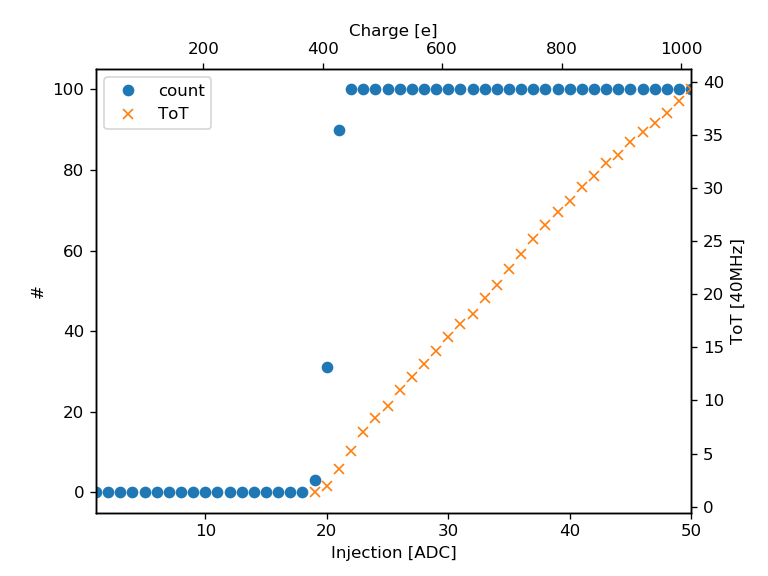

In [7]:
conversion_factor = np.mean(inj_high/injlist)
    
approx_threshold_dac = injlist[np.argmin( np.abs(cnt - repeat/2) )]
approx_threshold = approx_threshold_dac * conversion_factor
charge_threshold = approx_threshold_dac * CAPCAL
print "approx. th = %d DAC = %.3f V = %g e-" % (approx_threshold_dac, approx_threshold, charge_threshold)

sigma_dac = injlist[np.argmin( np.abs(cnt - repeat * 0.84) )] - injlist[np.argmin( np.abs(cnt - repeat * 0.16) )]
print "sigma %d DAC = %.3f V = %g e-" % (sigma_dac, sigma_dac * conversion_factor, sigma_dac * CAPCAL)  

fig,ax = plt.subplots(1,1)
ax.plot(injlist, cnt, "C0o", label="count")
ax2 = ax.twiny()
ax3 = ax.twinx()
ax3.plot(injlist,tot,"C1x",label="ToT")
ax.plot([],[],"C1x",label="ToT")

ax.set_xlabel("Injection [ADC]")
ax.set_ylabel("#")
ax3.set_ylabel("ToT [40MHz]")
ax2.set_xlabel("Charge [e]")
ax.set_xbound(np.min(injlist), np.max(injlist))
ax2.set_xbound(np.min(injlist) * CAPCAL, np.max(injlist) * CAPCAL)
ax.legend()

## run threshold scan using injection_scan

2022-02-02 17:22:34,250 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-02 17:22:34,273 [INFO ] (MainThread) idb = 20
2022-02-02 17:22:34,288 [INFO ] (MainThread) idb = 367.5 nA
2022-02-02 17:22:34,303 [INFO ] (MainThread) Initializing InjectionScan
2022-02-02 17:22:34,858 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.01324044508196, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0632804013424586, 'VDDD OC': False, 'VPC [mA]': 0.03049987094288338, 'VPCSWSF [mA]': 0.02951465106343792, 'VDDA [V]': 1.8048574894894895, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-02-02 17:22:34,937 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:22:34,990 [INFO ] (MainThread) Temperature (C): 29.7

2022-02-02 17:22:39,765 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:22:39,834 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:22:39,888 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:22:39,950 [INFO ] (MainThread) Temperature (C): 29.864511
2022-02-02 17:22:40,003 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:22:40,065 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:22:40,134 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:22:40,188 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:22:40,250 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:22:40,266 [INFO ] (MainThread) Temperature: 29.7 C
2022-02-02 17:22:40,351 [INFO ] (MainThread) Closing socket connection


0 24077 100.000% 0.000s 8026hits 0errs
data (inj_n 100,inj_loop 50): INJ=5000 MONO=3026 MON=0
0 8026 100.000% 0.132s 3026hits 0errs
3026


<IPython.core.display.Javascript object>


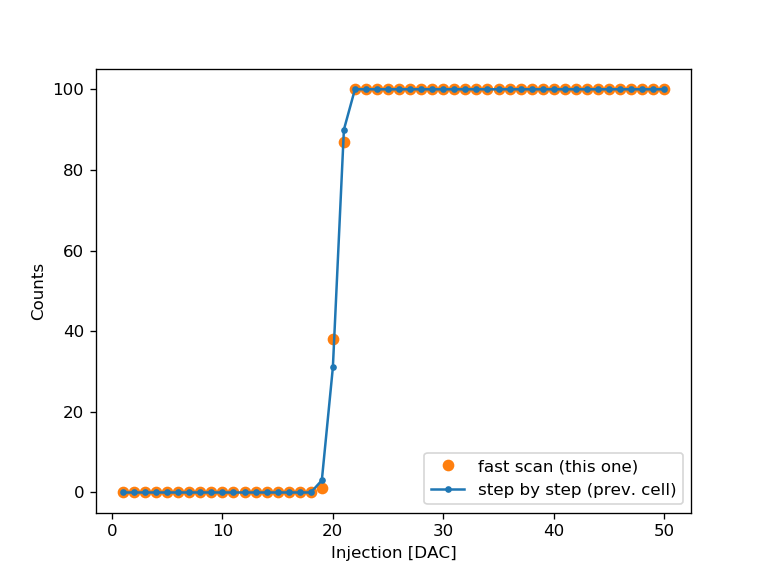

In [13]:
chip.set_vh_dacunits(80,1)  # The functions below change vl w.r.t. vh
chip.set_idb_dacunits(20,1)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

injlist = np.arange(50,0,-1)
output_filename=scans.start(
    collist=[col_to_inject], rowlist=[row_to_inject],
    injlist=injlist, thlist=None, phaselist=None,
    with_mon=False, n_mask_col=1, debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits)

uni,u_cnt=np.unique(hits["inj"],return_counts=True)
data=np.zeros(len(injlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(injlist-u))
    data[a]=u_cnt[u_i]

plt.figure()
plt.plot(injlist,data,"C1o",label="fast scan (this one)")
plt.plot(injlist,cnt,"C0.-",label="step by step (prev. cell)") ### step by step
plt.xlabel("Injection [DAC]")
plt.ylabel("Counts")
plt.legend();

# Global TH scan

2022-02-02 17:23:42,766 [INFO ] (MainThread) Initializing InjectionScan
2022-02-02 17:23:43,336 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 78.51981992834118, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0632804013424586, 'VDDD OC': False, 'VPC [mA]': -0.1709992413882244, 'VPCSWSF [mA]': -0.26913353693405057, 'VDDA [V]': 1.8038584294294295, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10109892318840588}
2022-02-02 17:23:43,421 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:43,483 [INFO ] (MainThread) Temperature (C): 29.740564
2022-02-02 17:23:43,536 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:43,599 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:43,653 [INF

2022-02-02 17:23:48,365 [INFO ] (MainThread) Temperature (C): 29.864511
2022-02-02 17:23:48,434 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:48,496 [INFO ] (MainThread) Temperature (C): 29.740564
2022-02-02 17:23:48,549 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:48,612 [INFO ] (MainThread) Temperature (C): 29.883738
2022-02-02 17:23:48,665 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:23:48,681 [INFO ] (MainThread) Temperature: 29.8 C
2022-02-02 17:23:48,766 [INFO ] (MainThread) Closing socket connection


0 22130 100.000% 0.000s 7377hits 0errs
data (inj_n 100,inj_loop 50): INJ=5000 MONO=2377 MON=0
0 7377 100.000% 0.115s 2377hits 0errs
2377 2377
gl_th 24


<IPython.core.display.Javascript object>


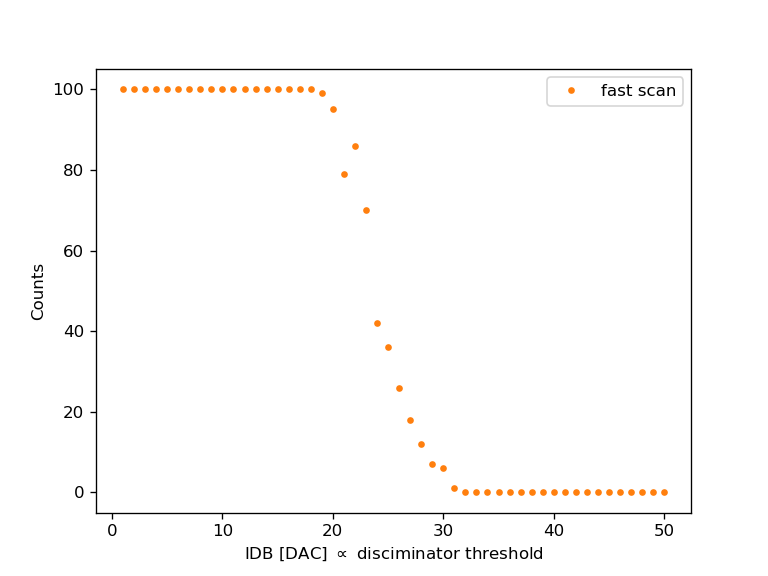

In [14]:
inj_height_dac = 21  # On the threshold

chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(40+inj_height_dac,0)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)

# ## step by step 
# if False:
#     cnt=np.empty(len(thlist))
#     print "inj all_hits hits aveToT"
#     for th_i,th in enumerate(thlist):
#         chip.set_idb_dacunits(th,0)
#         chip.write_conf()
#         for _ in range(5):
#             chip['fifo'].reset()
#             time.sleep(0.002)
#         chip.set_monoread()
#         chip["inj"].start()
#         while not chip['inj'].is_ready:
#             time.sleep(0.001)
#         time.sleep(0.2)
#         x = chip['fifo'].get_data()
#         ix = chip.interpret_data(x)
#         ix_inj=ix[np.bitwise_and(ix["col"]==col_to_inject, ix["row"]==row_to_inject)]
#         print th,len(ix),len(ix_inj),np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
#         cnt[th_i]=len(ix_inj)
#     plt.plot(thlist,cnt,"C0.-",label="step by step")
    
## fast scan
thlist = np.arange(50,0,-1)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
    collist=[col_to_inject], rowlist=[row_to_inject],
    injlist=None, thlist=thlist, phaselist=None,
    with_mon=False, n_mask_col=1, debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits),
hits=hits[np.bitwise_and(hits["col"]==col_to_inject,hits["row"]==row_to_inject)]
print len(hits)

uni,u_cnt=np.unique(hits["th"],return_counts=True)
data=np.zeros(len(thlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(thlist-u))
    data[a]=u_cnt[u_i]
gl_th=thlist[np.argmin(np.abs(data-50))]
print "gl_th",gl_th

plt.figure()
plt.plot(thlist,data,"C1.",label="fast scan")
plt.xlabel("IDB [DAC] $\\propto$ disciminator threshold")
plt.ylabel("Counts")
plt.legend()

# phase scan

In [16]:
#gl_th=4 ## from gl_th scan
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(80+40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()

phaselist=np.arange(0,48,1)
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
    collist=[col_to_inject], rowlist=[row_to_inject],
    injlist=None, thlist=None, phaselist=phaselist,
    with_mon=False, n_mask_col=1, debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_best_phase()
ana.run()
with tb.open_file(fev) as f:
    phase=f.root.BestPhase[0]["phase"]
with tb.open_file(fev) as f:
    hits=f.root.LEHist[:]
plt.imshow(np.transpose(hits[0]["LE"]),origin="bottom left",aspect="auto")
plt.plot([phase,phase],[0,63],"w--")
plt.ylim(0,63)
plt.colorbar()

2022-02-02 17:41:28,246 [INFO ] (MainThread) Initializing InjectionScan
2022-02-02 17:41:28,826 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.51981992834118, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0632804013424586, 'VDDD OC': False, 'VPC [mA]': 0.056499756404961805, 'VPCSWSF [mA]': 0.02751365817903264, 'VDDA [V]': 1.8038584294294295, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8045472377622378, 'BiasSF [mA]': 0.10059447096451782}
2022-02-02 17:41:28,911 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:41:28,964 [INFO ] (MainThread) Temperature (C): 29.845300
2022-02-02 17:41:29,028 [INFO ] (MainThread) Temperature (C): 29.702135
2022-02-02 17:41:29,096 [INFO ] (MainThread) Temperature (C): 29.682945
2022-02-02 17:41:29,150 [INF

2022-02-02 17:41:34,684 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:41:34,746 [INFO ] (MainThread) Temperature (C): 29.883738
2022-02-02 17:41:34,815 [INFO ] (MainThread) Temperature (C): 29.721342
2022-02-02 17:41:34,868 [INFO ] (MainThread) Temperature (C): 29.883738
2022-02-02 17:41:34,884 [INFO ] (MainThread) Temperature: 29.8 C
2022-02-02 17:41:34,969 [INFO ] (MainThread) Closing socket connection


0 28799 100.000% 0.000s 9600hits 0errs
data (inj_n 100,inj_loop 48): INJ=4800 MONO=4800 MON=0
0 9600 100.000% 0.201s 4800hits 0errs
AnalyzeHits: le_cnts will be analyzed


ValueError: no field of name collist

In [ ]:
#gl_th=4
#phase=6
chip.set_vl_dacunits(40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()
chip["inj"].set_phase(phase)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3, col_to_inject, row_to_inject]
injlist=np.arange(1,80,1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
reload(analyze_hits)
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_apply_ts_inj_window()
ana.init_delete_noninjected()
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_cnts as analyze_cnts
ana=analyze_cnts.AnalyzeCnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
reload(analyze_le_cnts)
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

In [ ]:
with tb.open_file(fev) as f:
    le=f.root.LECnts[:]
    le_fit=f.root.LEScurveFit[:]
    cnt=f.root.Cnts[:]
    cnt_fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(1,1)
import tjmonopix.analysis.utils as utils
x=np.append(np.arange(1,np.min(cnt["inj"])),cnt["inj"])
y=np.append(np.zeros(len(x)-len(cnt["cnt"])),cnt["cnt"])
ax.plot(x,y,"C0.",label="all")
A=cnt_fit[0]["A"]
mu=cnt_fit[0]["mu"]
sigma=cnt_fit[0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu,sigma_fit=sigma,reverse=False)
ax.plot(x,y,"C0-")
print "all mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu,mu*CAPCAL,sigma,sigma*CAPCAL)

tmp=le[le["toa"]==12]
x=np.append(np.arange(1,np.min(tmp["inj"])),tmp["inj"])
y=np.append(np.zeros(len(x)-len(tmp["cnt"])),tmp["cnt"])
ax.plot(x,y,"C1.",label="in-time")
A=le_fit[le_fit["toa"]==12][0]["A"]
mu_in=le_fit[le_fit["toa"]==12][0]["mu"]
sigma_in=le_fit[le_fit["toa"]==12][0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu_in,sigma_fit=sigma_in,reverse=False)
ax.plot(x,y,"C1-")
ax.set_xbound(0,np.max(cnt["inj"]))
ax2=ax.twiny()
ax2.set_xbound(0,np.max(cnt["inj"])*CAPCAL)
ax.set_xlabel("Injection [ADU]")
ax2.set_xlabel("Charge [e]")
ax.set_ylabel("#")
print "intime mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu_in,mu_in*CAPCAL,sigma_in,sigma_in*CAPCAL)
print "over drive %.3f ADU (%.2f e)"%(mu_in-mu, (mu_in-mu)*CAPCAL)
ax.legend()